In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml
import pickle
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmse
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '063_publisher_pivot_genre'
competition: atmacup8
description: 'pub_to_category_pivot の genre'
seed: 1019
training:
    validation: 'group' 
    num_folds: 5
    num_rounds: 10000
    early_stopping_rounds: 1000
    verbose_eval: 20
    sample_weight_division: 0.01  # 10/2/1
    sample_weight_threshold: 1000
lgbm_params:
    objective: regression
    learning_rate: 0.01
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
# target や weight の用意
target_columns = ['Global_Sales']
train_target_columns = target_columns + ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for c in train_target_columns:
    df_train.loc[:, 'mod_' + c] = df_train.loc[:, c].apply(lambda x: np.log1p(x))
df_train['target'] = df_train.loc[:, 'mod_Global_Sales']

In [7]:
df_base_train = df_train.loc[:, ['id']]
df_base_test = df_test.loc[:, ['id']]

train_others = {
    'main': df_train.copy(),
    'another': df_test.copy()
}
test_others = {
    'main': df_test.copy(),
    'another': df_train.copy(),
}

In [8]:
from mykaggle.feature.le import LE
from mykaggle.feature.score import Score
from mykaggle.feature.score_tbd import ScoreTBD
from mykaggle.feature.multi_platform import MultiPlatform
from mykaggle.feature.other_platforms import OtherPlatforms
from mykaggle.feature.ce import CE
from mykaggle.feature.original import Original
from mykaggle.feature.dev_to_category import DevToCategory
from mykaggle.feature.pub_to_category import PubToCategory
from mykaggle.feature.pub_to_category_pivot import PubToCategoryPivot

In [9]:
original_train = Original(train=True)
original_test = Original(train=False)
le_train = LE(train=True)
le_test = LE(train=False)
score_train = Score(train=True)
score_test = Score(train=False)
score_tbd_train = ScoreTBD(train=True)
score_tbd_test = ScoreTBD(train=False)
mp_train = MultiPlatform(train=True)
mp_test = MultiPlatform(train=False)
op_train = OtherPlatforms(train=True)
op_test = OtherPlatforms(train=False)
ce_train = CE(train=True)
ce_test = CE(train=False)
dtc_train = DevToCategory(train=True)
dtc_test = DevToCategory(train=False)
ptc_train = PubToCategory(train=True)
ptc_test = PubToCategory(train=False)
ptcp_train = PubToCategoryPivot(train=True)
ptcp_test = PubToCategoryPivot(train=False)

In [10]:
df_f_train = df_base_train.copy()
df_f_test = df_base_test.copy()

df_f_train = original_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = original_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = le_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = le_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = score_tbd_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = score_tbd_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = mp_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = mp_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = op_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = op_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ce_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ce_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = dtc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = dtc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ptc_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ptc_test(df_f_test, others=test_others, use_cache=False, save_cache=True)
df_f_train = ptcp_train(df_f_train, others=train_others, use_cache=False, save_cache=True)
df_f_test = ptcp_test(df_f_test, others=test_others, use_cache=False, save_cache=True)

df_f_train.shape, df_f_test.shape

before MultiIndex([('Publisher',             ''),
            (    'count',       'Action'),
            (    'count',    'Adventure'),
            (    'count',     'Fighting'),
            (    'count',         'Misc'),
            (    'count',     'Platform'),
            (    'count',       'Puzzle'),
            (    'count',       'Racing'),
            (    'count', 'Role-Playing'),
            (    'count',      'Shooter'),
            (    'count',   'Simulation'),
            (    'count',       'Sports'),
            (    'count',     'Strategy')],
           names=[None, 'Genre'])
after ['count_id_pivotby_Publisher_for_Genre_Action', 'count_id_pivotby_Publisher_for_Genre_Adventure', 'count_id_pivotby_Publisher_for_Genre_Fighting', 'count_id_pivotby_Publisher_for_Genre_Misc', 'count_id_pivotby_Publisher_for_Genre_Platform', 'count_id_pivotby_Publisher_for_Genre_Puzzle', 'count_id_pivotby_Publisher_for_Genre_Racing', 'count_id_pivotby_Publisher_for_Genre_Role-Playing', 'coun

((8359, 68), (8360, 68))

In [11]:
df_f_train

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,Year_of_Release,le_Platform,le_Genre,le_Developer,le_Rating,Critic_Score,User_Score,Critic_Count,User_Count,...,count_id_pivotby_Publisher_for_Genre_Fighting,count_id_pivotby_Publisher_for_Genre_Misc,count_id_pivotby_Publisher_for_Genre_Platform,count_id_pivotby_Publisher_for_Genre_Puzzle,count_id_pivotby_Publisher_for_Genre_Racing,count_id_pivotby_Publisher_for_Genre_Role-Playing,count_id_pivotby_Publisher_for_Genre_Shooter,count_id_pivotby_Publisher_for_Genre_Simulation,count_id_pivotby_Publisher_for_Genre_Sports,count_id_pivotby_Publisher_for_Genre_Strategy
0,0,NaN,26,0,1512,2,0.74,0.79,17.0,22.0,...,11.0,21.0,8.0,8.0,3.0,0.0,10.0,0.0,0.0,2.0
1,1,NaN,26,0,1512,2,0.78,0.66,22.0,28.0,...,0.0,0.0,0.0,0.0,2.0,2.0,19.0,6.0,0.0,10.0
2,2,NaN,19,0,1512,2,0.73,0.74,5.0,10.0,...,11.0,21.0,8.0,8.0,3.0,0.0,10.0,0.0,0.0,2.0
3,3,NaN,0,0,977,6,NaN,NaN,NaN,NaN,...,37.0,30.0,21.0,22.0,36.0,28.0,40.0,9.0,56.0,17.0
4,4,NaN,26,0,1512,2,0.76,0.78,8.0,13.0,...,11.0,21.0,8.0,8.0,3.0,0.0,10.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,8354,2016.0,13,12,1095,6,0.78,0.80,57.0,569.0,...,0.0,1.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,13.0
8355,8355,2016.0,13,12,977,6,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,2.0,1.0
8356,8356,2017.0,20,0,977,6,NaN,NaN,NaN,NaN,...,0.0,5.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,2.0
8357,8357,2017.0,18,8,977,6,NaN,NaN,NaN,NaN,...,37.0,62.0,52.0,22.0,47.0,64.0,40.0,13.0,134.0,35.0


In [12]:
# drop some columns
df_f_train = df_f_train.drop(['le_Developer'], axis=1)
df_f_test = df_f_test.drop(['le_Developer'], axis=1)
df_f_train.shape, df_f_test.shape

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((8359, 67), (8360, 67))

In [13]:
df_f_train.head().T

,0,1,2,3,4
id,0,1,2,3,4
Year_of_Release,NaN,NaN,NaN,NaN,NaN
le_Platform,26,26,19,0,26
le_Genre,0,0,0,0,0
le_Rating,2,2,2,6,2
...,...,...,...,...,...
count_id_pivotby_Publisher_for_Genre_Role-Playing,0,2,0,28,0
count_id_pivotby_Publisher_for_Genre_Shooter,10,19,10,40,10
count_id_pivotby_Publisher_for_Genre_Simulation,0,6,0,9,0
count_id_pivotby_Publisher_for_Genre_Sports,0,0,0,56,0


In [14]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from mykaggle.feature.te import TE
from mykaggle.feature.te_other_aggs import TEOtherAggs
from mykaggle.feature.te_year_platform import TEYearPlatform
from mykaggle.feature.te_year_genre import TEYearGenre
from mykaggle.feature.year_rank4 import YearRank4


te_train = TE(train=True)
te_test = TE(train=False)
te_oa_train = TEOtherAggs(train=True)
te_oa_test = TEOtherAggs(train=False)
# te_yp_train = TEYearPlatform(train=True)
# te_yp_test = TEYearPlatform(train=False)
# te_yg_train = TEYearGenre(train=True)
# te_yg_test = TEYearGenre(train=False)
year_rank_train = YearRank4(train=True)
year_rank_test = YearRank4(train=False)


def get_oof_feature(
    df_train: pd.DataFrame, df_valid: pd.DataFrame, y_train: np.ndarray,
    df_train_original: pd.DataFrame, df_valid_original: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train.loc[:, 'target'] = y_train.copy()
    _train_others = copy.deepcopy(train_others)
    _test_others = copy.deepcopy(test_others)
    _train_others['main'] = df_train_original.copy().reset_index().drop('index', axis=1)
    _train_others['another'] = df_valid_original.copy().reset_index().drop('index', axis=1)
    _test_others['main'] = df_valid_original.copy().reset_index().drop('index', axis=1)
    _test_others['another'] = df_train_original.copy().reset_index().drop('index', axis=1)
    df_train = df_train.reset_index().drop('index', axis=1)
    df_valid = df_valid.reset_index().drop('index', axis=1)
    df_train = te_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = te_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = te_oa_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = te_oa_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_yp_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_yp_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
#     df_train = te_yg_train(df_train, others=_train_others, use_cache=False, save_cache=False)
#     df_valid = te_yg_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    df_train = year_rank_train(df_train, others=_train_others, use_cache=False, save_cache=False)
    df_valid = year_rank_test(df_valid, others=_test_others, use_cache=False, save_cache=False)
    return df_train.drop(['id', 'target'], axis=1), df_valid.drop('id', axis=1)

In [16]:
def train(
    settings: Dict[str, Any],
    logger: MLLogger,
    df: pd.DataFrame,
    df_original: pd.DataFrame,
    y: np.ndarray,
    ckptdir: Path
) -> Tuple:
    logger.log_params(settings['training'])
    logger.log_params(settings['lgbm_params'])
    X = df.copy()
    lgbm_params = settings['lgbm_params']
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    importances = pd.DataFrame()
    split_file = f'{settings["training"]["validation"]}_{settings["training"]["num_folds"]}fold.pkl'
    splits = pickle.load(open(datadir / split_file, 'rb'))

    for i, (train_idx, valid_idx) in enumerate(splits): 
        x_train, y_train = X.iloc[train_idx], y[train_idx]
        x_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
        x_train, x_valid = get_oof_feature(
            x_train, x_valid, y_train,
            df_original.iloc[train_idx], df_original.iloc[valid_idx]
        )
        train_data = lgb.Dataset(x_train.values, label=y_train)
        valid_data = lgb.Dataset(x_valid.values, label=y_valid)

        with timer(prefix='train fold={} '.format(i + 1)):
            clf = lgb.train(
                lgbm_params,
                train_data, 
                num_boost_round=settings['training']['num_rounds'],
                valid_names=['train', 'valid'],
                valid_sets=[train_data, valid_data],  
                early_stopping_rounds=settings['training']['early_stopping_rounds'],
                feval=rmse,
                verbose_eval=settings['training']['verbose_eval']
            )
        pred_i = clf.predict(x_valid.values)
        oof_pred[valid_idx] = pred_i
        models.append(clf)
        importances = compute_importances(importances, x_train.columns, models[i], fold=i)
        fold_score = mean_squared_error(y_valid, pred_i) ** 0.5
        logger.log_metric(f'rmsle_fold_{i}', fold_score)
        print(f'Fold {i} RMSLE: {fold_score:.4f}')
        clf.save_model(str(ckptdir / f'model.txt'))
        logger.log_artifact(str(ckptdir / f'model.txt'), artifact_path=f'{i}')

    score = mean_squared_error(y, oof_pred) ** 0.5
    logger.log_metric(f'RMSLE', score)
    print('FINISHED; whole score: {:.4f}'.format(score))
    save_importances(importances, ckptdir)
    return oof_pred, models, score, importances

In [17]:
def visualize_oof(
    y_true: np.ndarray, y_pred: np.ndarray
) -> None:
    plt.figure(figsize=(5, 5))
    plt.plot([-100, 5000], [-100, 5000], color='black')
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.xlim(-100, 4000)
    plt.ylim(-100, 4000)
    plt.xlabel('True')
    plt.ylabel('Pred')


def predict(
    models: List[lgb.Booster],
    df_test: pd.DataFrame,
    df_train: pd.DataFrame,
    df_test_original: pd.DataFrame
) -> np.ndarray:
    '''
    fold 分のモデルと test の特徴 dataframe を受け取って、予測したものを返します。
    :param models: kfold 分のモデル
    :param test_df: test dataset の特徴
    :return: 予測
    '''
    _, test = get_oof_feature(
        df_train.copy(), df_test.copy(), df_train['target'].values, df_train.copy(), df_test_original.copy()
    )
    preds = np.array([model.predict(test) for model in models])
    preds = np.expm1(preds)
    preds = np.mean(preds, axis=0)
    return preds

    
def submit(preds: np.ndarray, ckptdir: Path) -> pd.DataFrame:
    '''
    test data の prediction を受け取って submission ファイルを作成します。
    :param preds: test data の予測
    :param ckptdir: 保存場所
    :return: submission df
    '''
    sub_df = pd.DataFrame({ 'Global_Sales': preds })
    sub_df.to_csv(ckptdir / f'{settings["name"]}.csv', index=False)
    return sub_df

In [18]:
logger = MLLogger('cfiken', ckptdir)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2178
[LightGBM] [Info] Number of data points in the train set: 6687, number of used features: 72
[LightGBM] [Info] Start training from score 3.008886
Training until validation scores don't improve for 1000 rounds
[20]	train's rmsle: 1.29096	valid's rmsle: 1.20819
[40]	train's rmsle: 1.18932	valid's rmsle: 1.14806
[60]	train's rmsle: 1.11196	valid's rmsle: 1.10248
[80]	train's rmsle: 1.04806	valid's rmsle: 1.06365
[100]	train's rmsle: 0.996619	valid's rmsle: 1.03091
[120]	train's rmsle: 0.954021	valid's rmsle: 1.0051
[140]	train's rmsle: 0.918467	valid's rmsle: 0.985287
[160]	train's rmsle: 0.887114	valid's rmsle: 0.968063
[180]	train's rmsle: 0.860531	valid's rmsle: 0.955894
[200]	train's rmsle: 0.834652	valid's rmsle: 0.942069
[220]	train's rmsle: 0.813537	valid's rmsle: 0.93208
[240]	train's r

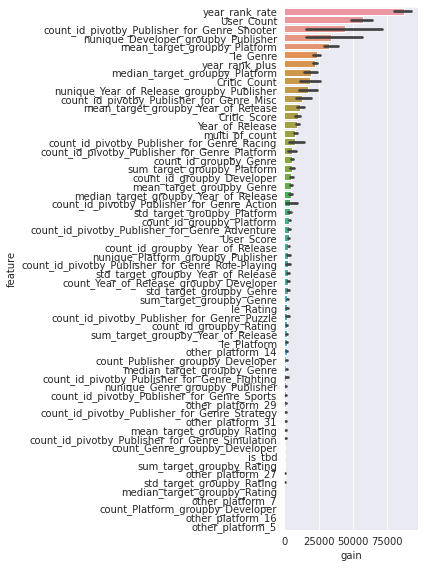

In [19]:
with logger.start(experiment_name=settings['competition'], run_name=settings['name']):
    oof, models, cv, importances = train(
        settings,
        logger,
        df_f_train,
        df_train,
        df_train.loc[:, 'target'].values,
        ckptdir
    )
    preds = predict(models, df_f_test, df_train, df_test)
    sub_df = submit(preds, ckptdir)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


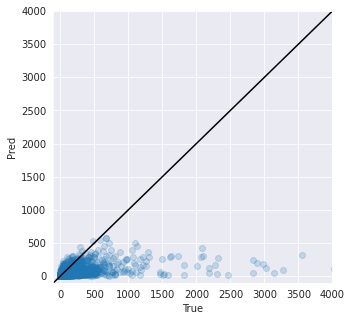

In [20]:
visualize_oof(np.expm1(df_train.loc[:, 'target'].values), np.expm1(oof))